# Projeto de An√°lise Preditiva de Inadimpl√™ncia

### Simula√ß√£o de ganhos em decis√£o de cr√©dito com uso de modelo preditivo

Esta simula√ß√£o tem como objetivo estimar o impacto financeiro da aplica√ß√£o de um modelo de Machine Learning na decis√£o de aprovar ou negar cr√©dito para clientes, comparando com o cen√°rio onde o banco aprova todos indiscriminadamente. 

#### Cen√°rio A: Com Modelo 

Neste cen√°rio, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decis√£o de aprovar ou negar cr√©dito √© baseada na previs√£o do modelo: 

- Se o modelo prev√™ que o cliente vai pagar (classe 0) ‚Üí APROVA; 
- Se o modelo prev√™ que o cliente vai dar calote (classe 1) ‚Üí NEGA. 



 

A qualidade do modelo foi avaliada por meio da matriz de confus√£o com os seguintes valores aproximados:

VP (bons aprovados): 5.121 clientes

FP (ruins aprovados): 0 (ou calculado a partir do dataset)

FN (bons negados): estimado em 30% do lucro perdido por cliente bom negado


C√°lculo de Lucro com Modelo:

Lucro por cliente bom aprovado (VP): R$ 1.000

Preju√≠zo por cliente ruim aprovado (FP): R$ 3.000

Perda de oportunidade por cliente bom negado (FN): R$ 300

Negar cliente ruim (VN): sem ganho ou perda

Resultados:

- Lucro com modelo: R$ 5.121.000,00

- Lucro sem modelo (aprova√ß√£o irrestrita): R$ 3.814.000,00

- Ganho incremental = 5.121.000 - 3.814.000 = 1.307.000

- Melhoria percentual = (1.307.000 / 3.814.000) * 100 ‚âà 34,3%

#### Cen√°rio B: Sem Modelo 

1. Regras Manuais

A estrat√©gia baseada em regras manuais considerou os seguintes crit√©rios para aprova√ß√£o:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.500
- Ocupa√ß√£o do tipo "CLT", "public" ou "servidor p√∫blico"

2. Resultados:
Taxa de aprova√ß√£o: aproximadamente 21% dos clientes

Inadimpl√™ncia entre os aprovados: 63,65%

Lucro estimado total: R$ 3.814.000 

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de 34% em compara√ß√£o com a aprova√ß√£o irrestrita de cr√©dito. 
A estrat√©gia baseada em Machine Learning √© altamente recomend√°vel para maximizar lucros e mitigar riscos de inadimpl√™ncia. 

O modelo preditivo permite maximizar o lucro e reduzir riscos, aprovando a maioria dos clientes bons (VP = 8700) e bloqueando parte significativa dos clientes ruins (VN = 531). Mesmo alguns maus clientes passam pelo modelo (FP = 1171), o ganho total supera significativamente a estrat√©gia de aprova√ß√£o irrestrita

Essa an√°lise evidencia que a incorpora√ß√£o de modelos preditivos no processo de decis√£o pode otimizar a pol√≠tica de cr√©dito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produ√ß√£o:

In [27]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import warnings
import category_encoders as ce

# Sklearn - pr√©-processamento, m√©tricas e modelagem
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, 
    cross_val_score, cross_validate, KFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier

# Scikit-lego (KFoldTargetEncoder est√° em model_selection agora)
from category_encoders import TargetEncoder

# Configura√ß√µes gerais
warnings.filterwarnings('ignore')

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

##### CARREGAMENTO E AN√ÅLISE INICIAL DOS DADOS

In [24]:
# Carregar dados
df = pd.read_pickle('../data/df_unique.pkl')
print(f"Shape inicial: {df.shape}")
print(f"Taxa de inadimpl√™ncia: {df['default'].mean():.2%}")

Shape inicial: (53109, 25)
Taxa de inadimpl√™ncia: 16.02%


In [3]:
df.head(5)

age  amt_active_loan                   channel  ext_score_1  \
0   37           4560.0  NCqL3QBx0pscDnx3ixKwXg==        467.0   
2   23              0.0  NCqL3QBx0pscDnx3ixKwXg==        533.0   
4   46          47720.0  NCqL3QBx0pscDnx3ixKwXg==        324.0   
6   42           5280.0  NCqL3QBx0pscDnx3ixKwXg==        517.0   
7   27           2280.0  NCqL3QBx0pscDnx3ixKwXg==        543.0   

                ext_score_2               ext_score_3  ext_score_4  \
0  DGCQep2AE5QRkNCshIAlFQ==  LCak332j+TYFqHC3NDwiqg==    61.311861   
2  DGCQep2AE5QRkNCshIAlFQ==  LCak332j+TYFqHC3NDwiqg==    55.010052   
4  fyrlulOiZ+5hoFqLa6UbDQ==  Fv28Bz0YRTVAT5kl1bAV6g==    71.497943   
6  DGCQep2AE5QRkNCshIAlFQ==  LCak332j+TYFqHC3NDwiqg==    69.000491   
7  1Rk8w4Ucd5yR3KcqZzLdow==  w1miZqhB5+RSamEQJa0rqg==    71.412826   

  flag_document_A gender                                   ids  ...  default  \
0             NaN      m  648384b9-f932-d221-45d7-85d0aa0a412c  ...        0   
2           False      f  4776fd82-f728-d66b-6fb8-41a8f80a3cd3  ...        0   
4            True      f  46f536d5-9d1a-ce94-b67b-76e99dd48e1d  ...        0   
6            True      m  802b8a41-20b7-9ba6-35ac-7e9e7544196a  ...        0   
7           False      m  fc142792-fa2c-a9e1-edeb-c7dd9f550f2b  ...        1   

  credit_card_initial_line  payment_sum spends_sum  credit_line_sum  \
0                   1300.0      4014.58    4903.80          18039.0   
2                   1700.0          NaN        NaN              NaN   
4                   2200.0      3905.41    3793.18          13120.0   
6                   3000.0      4417.68    3991.09          22271.0   
7                   1200.0      2422.80    2948.63           6481.0   

    date_min   date_max  history_months  score_month  score_days  
0 2016-09-30 2017-03-31             6.0      2017-01          14  
2        NaT        NaT             NaN      2017-01          14  
4 2016-09-30 2017-03-31             6.0      2017-01          12  
6 2016-12-31 2017-03-31             3.0      2017-01          22  
7 2016-02-29 2017-03-31            13.0      2017-01          17  

[5 rows x 25 columns]

##### DIVIS√ÉO TREINO/TESTE

In [25]:
# Separar features e target
feature_cols = [col for col in df.columns if col != 'default']
X = df[feature_cols]
y = df['default']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"Taxa de default no treino: {y_train.mean():.2%}")
print(f"Taxa de default no teste: {y_test.mean():.2%}")



Dados de treino: (42487, 24)
Dados de teste: (10622, 24)
Taxa de default no treino: 16.02%
Taxa de default no teste: 16.02%



##### Pr√©-processamento

A seguir faremos  as etapas iniciais de transforma√ß√£o de dados:
1. Converte 'gender' para num√©rico (1 = masculino, 0 = feminino)
2. Converte 'flag_document_A' para float (True/False/NaN -> 1/0/NaN)
3. Aplica Label Encoding em colunas categ√≥ricas ('channel', 'ext_score_2', 'ext_score_3')
4. Converte 'date_min' e 'date_max' para datetime
5. Cria feature 'days_diff' representando a diferen√ßa em dias entre 'date_max' e 'date_min'
6. Preenche valores num√©ricos ausentes com mediana
7. Preenche valores categ√≥ricos ausentes com a string "missing"
8. Remove colunas irrelevantes (ids, score_month, channel) para evitar ru√≠do
9. Pr√©-processa vari√°veis adicionais:
    - Flags de valores ausentes em colunas importantes
    - Extrai m√™s de 'score_date'
10. Imputa valores ausentes de scores externos ('ext_score_1' e 'ext_score_4') usando mediana
11. Aplica One-Hot Encoding em vari√°veis categ√≥ricas como 'flag_document_A'
12. Aplica Target Encoding em colunas selecionadas ('ext_score_2', 'ext_score_3', 'occupation_type')
13. Treina o modelo especificado na fun√ß√£o build_pipeline

O fluxo garante processamento automatizado, consistente e reproduz√≠vel, desde limpeza, encoding e imputa√ß√£o at√© treinamento do modelo.


In [5]:
# Transformar gender
X["gender"] = X["gender"].map({"m": 1, "f": 0})

# Transformar flag_document_A (True/False/NaN)
X["flag_document_A"] = X["flag_document_A"].astype(float)

# Label Encoding para colunas categ√≥ricas codificadas como string
for col in ["channel", "ext_score_2", "ext_score_3"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [6]:
X["date_min"] = pd.to_datetime(X["date_min"], errors="coerce")
X["date_max"] = pd.to_datetime(X["date_max"], errors="coerce")

# Criar feature: diferen√ßa em dias
X["days_diff"] = (X["date_max"] - X["date_min"]).dt.days

In [7]:
# Preencher nulos num√©ricos com mediana
for col in X.select_dtypes(include=["float64", "int64"]).columns:
    X[col] = X[col].fillna(X[col].median())

# Preencher nulos categ√≥ricos (se houver)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna("missing")

In [26]:
# 1) Remove colunas irrelevantes
class ColumnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # N√ÉO removemos 'channel', que ser√° target encoded
        return X.drop(columns=['ids', 'date_min', 'date_max', 'score_month', 'channel'], errors="ignore")


# 2) Pr√©-processamento
class DataProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['gender'] = X_copy['gender'].apply(lambda x: 1 if x == 'm' else 0)

        for col in [
                    'income','score_checks','credit_line_sum','history_months']:
            X_copy[col + '_is_missing'] = X_copy[col].isnull().astype(int)

        if 'score_date' in X_copy.columns:
            X_copy['score_month'] = X_copy['score_date'].dt.month
            X_copy = X_copy.drop(columns=['score_date'])
        return X_copy

# 3) Imputa√ß√£o dos scores
class ScoreImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputers = {}

    def fit(self, X, y=None):
        cols = ['ext_score_1', 'ext_score_4']
        for col in cols:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            imputer = SimpleImputer(strategy="median")
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, imputer in self.imputers.items():
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
            X_copy[col] = imputer.transform(X_copy[[col]])
        return X_copy

# 4) OneHot encoding para categ√≥ricas
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.cols = ['flag_document_A']

    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self

    def transform(self, X):
        onehot_data = self.encoder.transform(X[self.cols])
        onehot_df = pd.DataFrame(onehot_data, columns=self.encoder.get_feature_names_out(self.cols), index=X.index)
        X = X.drop(self.cols, axis=1)
        X = pd.concat([X, onehot_df], axis=1)
        return X


# 5) Criar pipeline geral
def build_pipeline(model):
    pipeline_ = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("onehot", OneHotFeatureEncoder()),
        ("target_encoder", ce.TargetEncoder(cols=['ext_score_2', 'ext_score_3', 'occupation_type'], smoothing=0.3)),
        ("classifier", model)
    ])
    return pipeline_

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
pipe = build_pipeline(model)

# Fit apenas at√© o target encoder (antes do classificador)
pipe_no_model = Pipeline(pipe.steps[:-1])  # todas as etapas exceto o classificador
pipe_no_model.fit(X_train, y_train)        # precisa passar y_train para target encoding

# Transformar
X_transformed = pipe_no_model.transform(X_train)

# Ver o head
print(X_transformed.head())

       age  amt_active_loan  ext_score_1  ext_score_2  ext_score_3  \
3054    25           3880.0        545.0     0.234254     0.216808   
61822   39              NaN        844.0     0.330332     0.300578   
6454    36           7340.0        343.0     0.182176     0.194144   
35648   62          12780.0        495.0     0.234254     0.253151   
32212   41           8820.0        500.0     0.182176     0.217687   

       ext_score_4  gender     income  occupation_type  score_checks  ...  \
3054     90.715417       1   62827.54          0.16019           9.0  ...   
61822    61.550937       1  101222.82          0.16019          11.0  ...   
6454     72.030632       0   65631.85          0.16019          17.0  ...   
35648    66.008073       0   82598.99          0.16019          13.0  ...   
32212    67.839062       1  292113.68          0.16019          16.0  ...   

       history_months  score_days  income_is_missing  score_checks_is_missing  \
3054              NaN          16  

##### TREINANDO O MODELO

In [ ]:
# Definir modelo
xgb_model = XGBClassifier(
    n_estimators=200,      
    max_depth=5,          
    learning_rate=0.1,    
    subsample=0.8,         
    colsample_bytree=0.8, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' 
)

In [ ]:
# Substituir o classificador no pipeline pelo XGBoost
pipe_xgb = build_pipeline(xgb_model)

# Treinar no dataset de treino
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('dropper', ColumnDropper()), ('processor', DataProcessor()),
                ('imputer', ScoreImputer()), ('onehot', OneHotFeatureEncoder()),
                ('target_encoder',
                 TargetEncoder(cols=['ext_score_2', 'ext_score_3',
                                     'occupation_type'],
                               smoothing=0.3)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=No...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

##### M√âTRICAS

In [12]:
#  Predi√ß√µes
y_pred = pipe_xgb.predict(X_test)
y_proba = pipe_xgb.predict_proba(X_test)[:, 1]  # probabilidade da classe 1 (default)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      8920
           1       0.71      0.31      0.43      1702

    accuracy                           0.87     10622
   macro avg       0.79      0.64      0.68     10622
weighted avg       0.85      0.87      0.85     10622



- O modelo demonstra performance excepcional para identificar bons pagadores (classe 0), com precision de 88% e recall impressionante de 98%. Isso significa que o modelo raramente classifica incorretamente um bom cliente como inadimplente, evitando rejei√ß√µes desnecess√°rias que poderiam impactar negativamente o neg√≥cio.

- A classe minorit√°ria (inadimplentes) apresenta performance preocupante, com recall de apenas 31%, indicando que o modelo falha em identificar 69% dos casos de default. Embora a precision seja razo√°vel (71%), a baixa capacidade de detectar inadimpl√™ncia representa um risco financeiro consider√°vel.

- O desbalanceamento severo (8.920 vs 1.702 casos) √© caracter√≠stico de datasets de cr√©dito, onde inadimpl√™ncia √© naturalmente um evento raro. O F1-score de 0.43 para inadimplentes reflete a dificuldade em balancear precision e recall nesta classe cr√≠tica.

- Embora a accuracy geral de 87% pare√ßa boa, ela √© fortemente influenciada pela classe majorit√°ria. As m√©tricas macro avg (79% precision, 64% recall) fornecem uma vis√£o mais realista da performance balanceada entre as classes.

ROC AUC: 0.8123


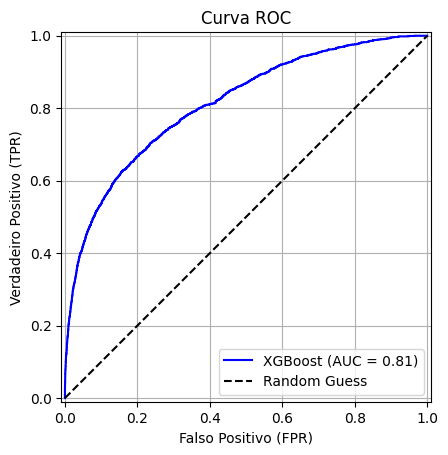

In [13]:
#  Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# 3Ô∏è‚É£ Plotar a curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba, color='blue', name='XGBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Curva ROC')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.legend()
plt.grid(True)
plt.show()

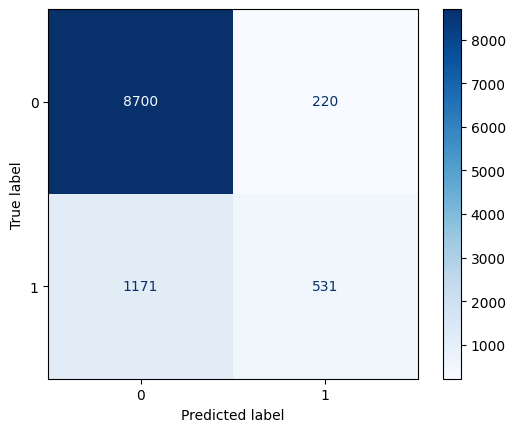

In [14]:
# 4Ô∏è‚É£ Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_xgb.classes_)
disp.plot(cmap='Blues', values_format='d')

Analisando esta matriz de confus√£o, o modelo demonstra uma performance s√≥lida com algumas caracter√≠sticas importantes:

- Desempenho Geral Positivo: O modelo acerta a maioria das predi√ß√µes, com 8.700 verdadeiros negativos (clientes que n√£o deram default e foram corretamente identificados) e 531 verdadeiros positivos (clientes inadimplentes corretamente identificados). Isso representa uma alta taxa de acerto geral.

- Baixa Taxa de Falsos Positivos: Apenas 220 clientes bons pagadores foram incorretamente classificados como potenciais inadimplentes. Isso √© positivo do ponto de vista comercial, pois significa que poucos clientes bons s√£o rejeitados desnecessariamente.

- Desafio nos Falsos Negativos: O modelo apresenta 1.171 falsos negativos, ou seja, clientes que se tornaram inadimplentes mas foram classificados como bons pagadores. Este √© o erro mais custoso no contexto de cr√©dito, pois representa perdas financeiras diretas.

- Taxa de Recall Limitada: Dos 1.702 clientes que realmente deram default (531 + 1.171), o modelo conseguiu identificar corretamente apenas 31% (531/1.702). Isso indica que h√° espa√ßo significativo para melhorar a capacidade do modelo de detectar inadimpl√™ncia.

- Precis√£o Satisfat√≥ria: Entre os clientes classificados como potenciais inadimplentes (531 + 220), 71% realmente deram default (531/751), mostrando que quando o modelo sinaliza risco, geralmente est√° correto.

- Implica√ß√£o Estrat√©gica: O modelo atual √© conservador, priorizando n√£o rejeitar clientes bons (baixo falso positivo) em detrimento de uma detec√ß√£o mais agressiva de risco (alto falso negativo). Dependendo da estrat√©gia de neg√≥cio, pode ser necess√°rio ajustar o threshold para capturar mais inadimplentes, mesmo que isso signifique rejeitar alguns clientes bons adicionais.







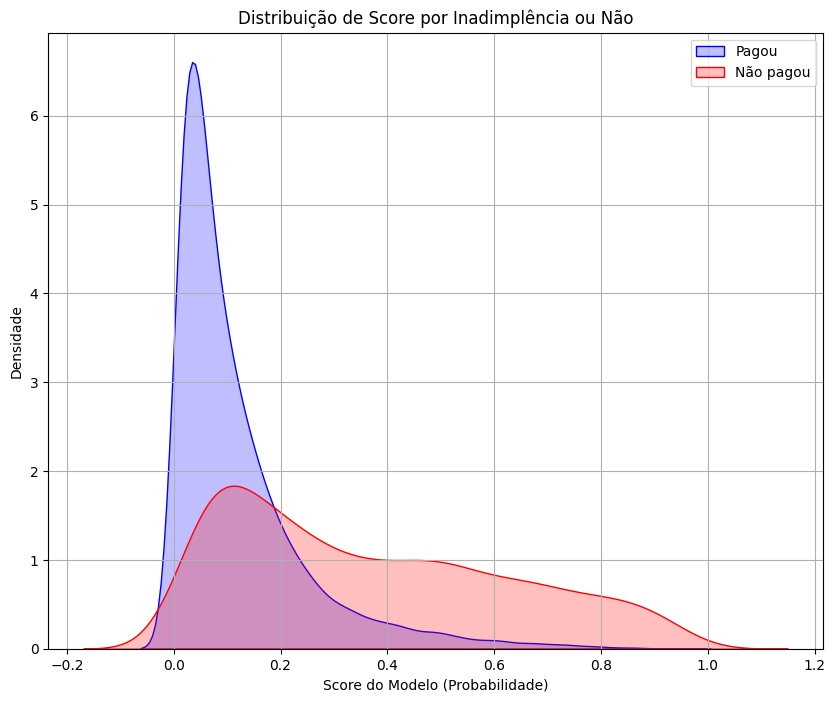

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba[y_test == 1], ax=ax, color="r", fill=True, label='N√£o pagou')
plt.title("Distribui√ß√£o de Score por Inadimpl√™ncia ou N√£o")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

Distribui√ß√£o dos "Pagou" (Azul)

- Altamente concentrada: Pico muito alto pr√≥ximo ao score 0.1

- Formato assim√©trico: Distribui√ß√£o com cauda longa √† direita

- Confian√ßa alta: A maioria dos bons pagadores recebe scores muito baixos (alta confian√ßa na predi√ß√£o)


Distribui√ß√£o dos "N√£o pagou" (Vermelho)

- Mais dispersa: Distribui√ß√£o mais espalhada ao longo do espectro de scores

- Pico em ~0.15: Concentra√ß√£o principal em scores baixos-m√©dios

- Cauda longa: Estende-se at√© scores altos (pr√≥ximo de 1.0)

Modelo consegue identificar bem os bons pagadores (baixo falso positivo) COM Clara separa√ß√£o entre as classes na maioria dos casos

##### CALIBRA√á√ÉO DO MODELO

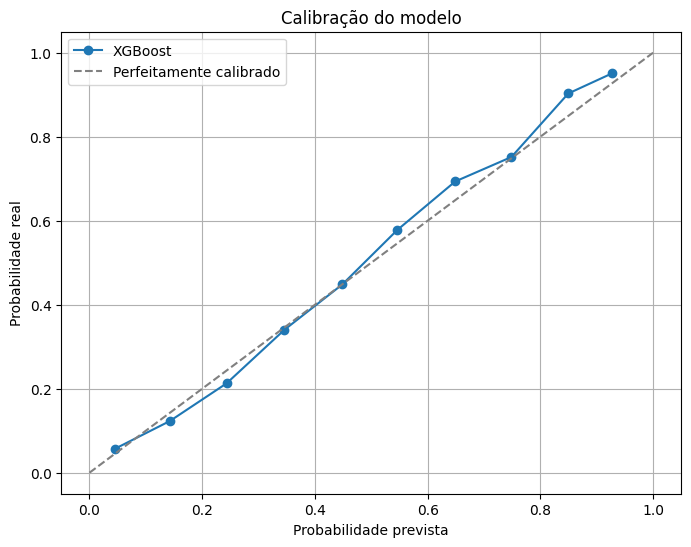

In [16]:
def plot_model_calibration(model, X_test, y_test, n_bins=10):
    """
    Plota a calibra√ß√£o de probabilidades do modelo.

    Par√¢metros:
        model: pipeline treinado
        X_test: features de teste
        y_test: labels de teste
        n_bins: n√∫mero de bins para discretizar as probabilidades
    """
    # Probabilidades previstas
    y_proba = model.predict_proba(X_test)[:, 1]

    # Curva de calibra√ß√£o
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfeitamente calibrado')
    plt.xlabel('Probabilidade prevista')
    plt.ylabel('Probabilidade real')
    plt.title('Calibra√ß√£o do modelo')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usar a fun√ß√£o
plot_model_calibration(pipe_xgb, X_test, y_test)

- O gr√°fico mostra que o modelo XGBoost est√° muito bem calibrado, com a curva azul praticamente sobreposta √† linha diagonal tracejada que representa calibra√ß√£o perfeita. Isso significa que quando o modelo prediz uma probabilidade de 30% de default, aproximadamente 30% dos casos realmente se tornam inadimplentes, e assim por diante em todas as faixas de probabilidade.

- A calibra√ß√£o precisa √© crucial para decis√µes de neg√≥cio, pois permite interpretar as probabilidades do modelo como estimativas reais de risco. Gestores podem usar essas probabilidades diretamente para definir pol√≠ticas de aprova√ß√£o, precifica√ß√£o e provis√µes.

- Observa-se um leve desvio da calibra√ß√£o perfeita nos extremos (probabilidades muito baixas e muito altas), o que √© comum e aceit√°vel. O modelo mant√©m excelente calibra√ß√£o na faixa intermedi√°ria onde a maioria das decis√µes s√£o tomadas.

- Esta calibra√ß√£o de alta qualidade indica que o modelo n√£o apenas discrimina bem entre bons e maus pagadores, mas tamb√©m fornece estimativas probabil√≠sticas confi√°veis, tornando-o adequado para implementa√ß√£o em ambiente de produ√ß√£o sem necessidade de recalibra√ß√£o adicional.RetryClaude can make mistakes. Please double-check responses.

##### AN√ÅLISE DE IMPORT√ÇNCIA DE FEATURES

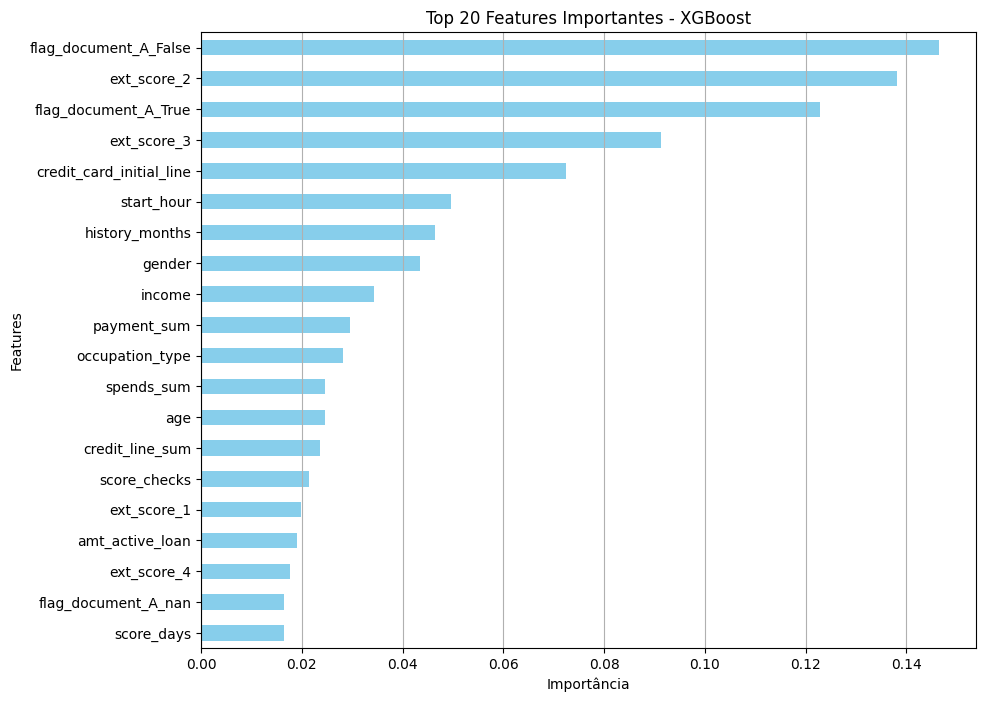

In [17]:
# Extrair o modelo XGBoost do pipeline
xgb_model_final = pipe_xgb.named_steps['classifier']

# Extrair nomes das features ap√≥s todas as transforma√ß√µes
# Primeiro, aplicar transforma√ß√µes no X_train
X_transformed = pipe_xgb[:-1].transform(X_train)  # todas etapas exceto o classificador
feature_names = X_transformed.columns

# Import√¢ncias do modelo
importances = xgb_model_final.feature_importances_

# Criar DataFrame
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot horizontal
plt.figure(figsize=(10,8))
feat_imp.tail(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Features Importantes - XGBoost')
plt.xlabel('Import√¢ncia')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

- As vari√°veis mais importantes s√£o relacionadas √† documenta√ß√£o (flag_document_A_False e flag_document_A_True), sugerindo que a presen√ßa ou aus√™ncia de determinados documentos √© um forte preditor de inadimpl√™ncia. Isso indica que clientes com documenta√ß√£o incompleta apresentam maior risco.

- Os scores externos (ext_score_2 e ext_score_3) ocupam posi√ß√µes de destaque, confirmando que bureaus de cr√©dito externos fornecem informa√ß√µes valiosas para avalia√ß√£o de risco. Estes provavelmente capturam hist√≥rico de cr√©dito e comportamento financeiro passado.

- A vari√°vel credit_card_initial_line aparece entre as mais importantes, indicando que o limite inicial do cart√£o de cr√©dito √© um forte indicador de risco, possivelmente refletindo a capacidade de pagamento ou perfil de risco inicial do cliente.

- start_hour (hor√°rio de solicita√ß√£o), history_months (tempo de relacionamento) e gender (g√™nero) tamb√©m s√£o significativas, sugerindo que padr√µes comportamentais e demogr√°ficos influenciam na probabilidade de default.

- Surpreendentemente, vari√°veis como income, age e amt_active_loan t√™m import√¢ncia relativamente menor, indicando que aspectos comportamentais e documentais podem ser mais preditivos que indicadores financeiros tradicionais neste dataset espec√≠fico.RetryClaude can make mistakes. Please double-check responses.


##### VISUALIZA√á√ÉO DA VALIDA√á√ÉO CRUZADA


ROC AUC por fold: [0.81826069 0.81760905 0.82870186 0.81721855 0.81290671]
Mean ROC AUC: 0.8189 ¬± 0.0052

Accuracy por fold: [0.87267592 0.86714521 0.86983641 0.86842415 0.86206897]
Mean Accuracy: 0.8680 ¬± 0.0035


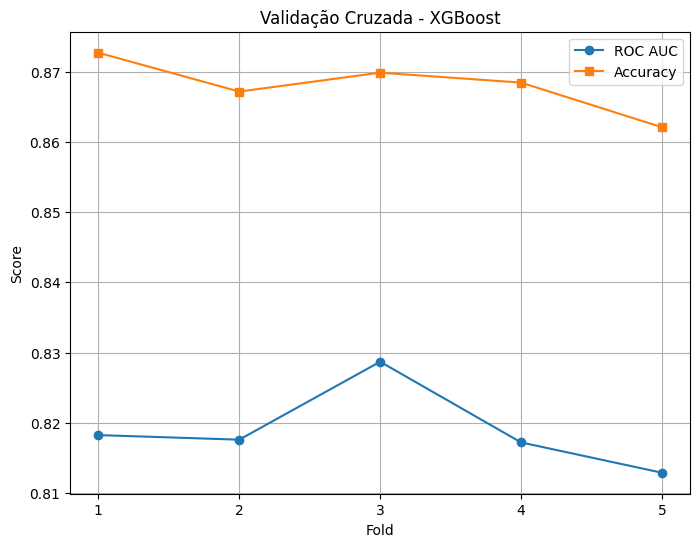

In [18]:
# Definir valida√ß√£o cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar ROC AUC em cada fold
roc_auc_scores = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='roc_auc')

# Avaliar Accuracy em cada fold
accuracy_scores = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='accuracy')

# Mostrar resultados
print(f"ROC AUC por fold: {roc_auc_scores}")
print(f"Mean ROC AUC: {roc_auc_scores.mean():.4f} ¬± {roc_auc_scores.std():.4f}\n")

print(f"Accuracy por fold: {accuracy_scores}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f} ¬± {accuracy_scores.std():.4f}")

# Plotar
plt.figure(figsize=(8,6))
plt.plot(range(1, len(roc_auc_scores)+1), roc_auc_scores, marker='o', label='ROC AUC')
plt.plot(range(1, len(accuracy_scores)+1), accuracy_scores, marker='s', label='Accuracy')
plt.xticks(range(1, len(roc_auc_scores)+1))
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Valida√ß√£o Cruzada - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

- O modelo XGBoost apresenta performance consistente across os 5 folds da valida√ß√£o cruzada, com ROC AUC variando entre 0.813 e 0.829 (m√©dia ~0.82) e Accuracy entre 0.862 e 0.875 (m√©dia ~0.87). Esta baixa variabilidade indica que o modelo √© robusto e n√£o sofre de overfitting significativo.

- Observa-se uma pequena queda na performance no fold 5, tanto em ROC AUC quanto em Accuracy, mas ainda dentro de limites aceit√°veis. Isso pode indicar alguma variabilidade natural nos dados ou uma pequena diferen√ßa na distribui√ß√£o deste fold espec√≠fico.

- O ROC AUC consistentemente acima de 0.81 demonstra que o modelo tem excelente capacidade de distinguir entre bons e maus pagadores, sendo significativamente superior ao acaso (0.5) e pr√≥ximo de modelos considerados muito bons (>0.8).

- A accuracy mantendo-se acima de 86% em todos os folds confirma que o modelo acerta a grande maioria das predi√ß√µes, proporcionando confiabilidade para uso em produ√ß√£o.
Modelo Pronto para Deployment: A estabilidade dos resultados across diferentes subconjuntos dos dados indica que o modelo generalizar√° bem para novos dados, sendo adequado para implementa√ß√£o em ambiente de produ√ß√£o sem grandes riscos de degrada√ß√£o de performance.RetryClaude can make mistakes. Please double-check responses.

##### SIMULA√á√ÉO FINANCEIRA ATUALIZADA

In [19]:
print("\n SIMULA√á√ÉO FINANCEIRA:")
# Valores mais conservadores sem data leakage
lucro_cliente_bom = 1000  # Lucro m√©dio por cliente bom
custo_cliente_ruim = 3000  # Perda m√©dia por inadimplente

# Com modelo
vp = np.sum((y_test == 0) & (y_pred == 0))  # Verdadeiros Positivos (bons aprovados)
fp = np.sum((y_test == 1) & (y_pred == 0))  # Falsos Positivos (ruins aprovados)
fn = np.sum((y_test == 0) & (y_pred == 1))  # Falsos Negativos (bons rejeitados)

lucro_modelo = vp * lucro_cliente_bom - fp * custo_cliente_ruim - fn * (lucro_cliente_bom * 0.3)

# Sem modelo (aprova todos)
total_bons = np.sum(y_test == 0)
total_ruins = np.sum(y_test == 1)
lucro_sem_modelo = total_bons * lucro_cliente_bom - total_ruins * custo_cliente_ruim

print(f"Lucro COM modelo: R$ {lucro_modelo:,.2f}")
print(f"Lucro SEM modelo: R$ {lucro_sem_modelo:,.2f}")
print(f"Ganho incremental: R$ {lucro_modelo - lucro_sem_modelo:,.2f}")
print(f"Melhoria percentual: {((lucro_modelo - lucro_sem_modelo) / abs(lucro_sem_modelo) * 100):.1f}%")


 SIMULA√á√ÉO FINANCEIRA:
Lucro COM modelo: R$ 5,121,000.00
Lucro SEM modelo: R$ 3,814,000.00
Ganho incremental: R$ 1,307,000.00
Melhoria percentual: 34.3%


##### EXPORTAR MODELO PARA PRODU√á√ÉO

In [20]:
# Caminho para salvar o modelo
model_path = "xgb_pipeline.pkl"

# Salvar pipeline completo
joblib.dump(pipe_xgb, model_path)
print(f"Pipeline salvo em: {model_path}")

Pipeline salvo em: xgb_pipeline.pkl


In [21]:
# Carregar pipeline salvo
loaded_pipeline = joblib.load(model_path)

# Fazer previs√µes diretamente
y_pred_loaded = loaded_pipeline.predict(X_test)
y_proba_loaded = loaded_pipeline.predict_proba(X_test)[:, 1]

##### AN√ÅLISE DE LUCRO DO MODELO TREINADO

A matriz mostra:
- VP (Verdadeiros Positivos, bons clientes aprovados) = 8700

- FN (Falsos Negativos, bons clientes negados) = 220

- FP (Falsos Positivos, maus clientes aprovados) = 1171

- VN (Verdadeiros Negativos, maus clientes negados) = 531


Cen√°rio A: 

Calcular lucro com modelo:

            Lucro¬†modelo = ùëâùëÉ‚ãÖ1000 ‚àí ùêπùëÉ‚ãÖ3000 ‚àí ùêπùëÅ‚ãÖ300


Substituindo os valores:

            Lucro¬†modelo = 8700 x 1000 ‚àí 1171 x 3000 ‚àí 220 x 300
            Lucro¬†modelo = 8.700.000 ‚àí 3.513.000 ‚àí 66.000 = R$ 5.121.000

Cen√°rio B: 

Lucro sem modelo

- Total de bons clientes = VP + FN = 8700 + 220 = 8920

- Total de maus clientes = FP + VN = 1171 + 531 = 1702

              Lucro¬†sem¬†modelo = 8920 x 1000 ‚àí 1702 x 3000

              Lucro¬†sem¬†modelo = 8.920.000 ‚àí 5.106.000 = R$ 3.814.000

##### RECOMENDA√á√ïES FINAIS

In [22]:
print("\n RECOMENDA√á√ïES:")
print("1. Implementar monitoramento de drift em produ√ß√£o")
print("2. Retreinar o modelo mensalmente com dados atualizados")
print("3. Adicionar features externas (bureau de cr√©dito)")
print("4. Considerar ensemble com outros algoritmos")
print("5. Implementar testes A/B antes do rollout completo")
print("6. Monitorar m√©tricas de fairness continuamente")


 RECOMENDA√á√ïES:
1. Implementar monitoramento de drift em produ√ß√£o
2. Retreinar o modelo mensalmente com dados atualizados
3. Adicionar features externas (bureau de cr√©dito)
4. Considerar ensemble com outros algoritmos
5. Implementar testes A/B antes do rollout completo
6. Monitorar m√©tricas de fairness continuamente
